In [1]:

# importing all libraries 
import numpy as np    
import pandas as pd
import os 
import cv2 as cv
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Rescaling,Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# converting data into train data from image generator
train_data = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/input/state-farm-distracted-driver-detection/imgs/train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(100, 100),
  batch_size=128,label_mode='categorical',)

Found 22424 files belonging to 10 classes.
Using 17940 files for training.


In [3]:
# converting data into validation data from image generator
val_data = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/input/state-farm-distracted-driver-detection/imgs/train',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(100, 100),
  batch_size=128,label_mode='categorical',)

Found 22424 files belonging to 10 classes.
Using 4484 files for validation.


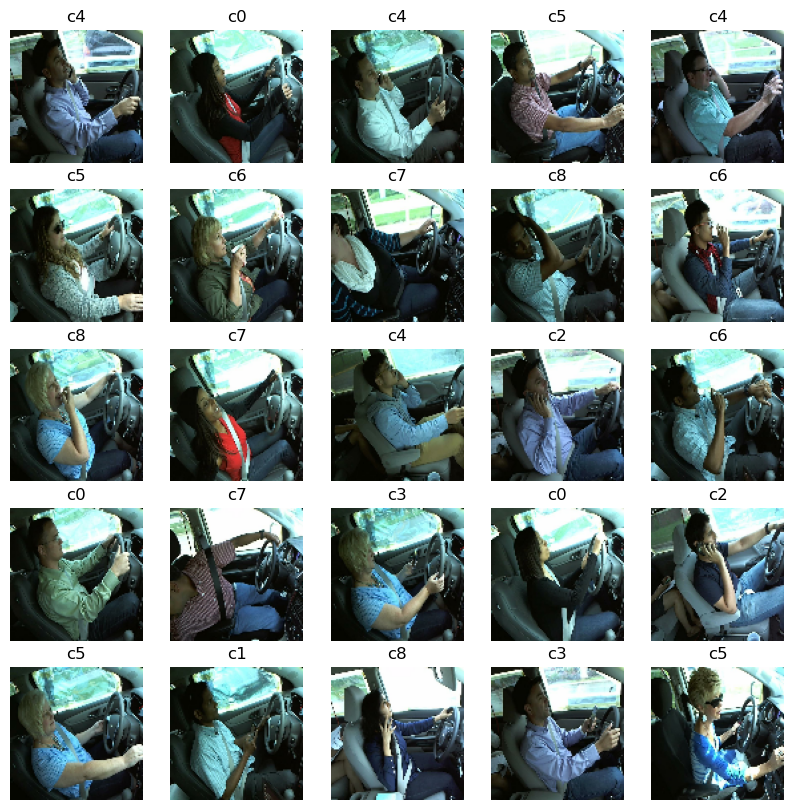

In [4]:
# showing some of the images
classes = train_data.class_names
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for images,labels in train_data.take(1):
    labels = labels.numpy()
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i].argmax()])
        plt.axis("off")

In [5]:
# creating our model
model = tf.keras.models.Sequential([
    Rescaling(scale = 1/255,input_shape=(100,100,3)),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.1),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.1),
    Flatten(),
    Dense(1024,activation='relu'),
    Dropout(0.1),
    Dense(512,activation='relu'),
    
    Dense(256,activation='relu'),
    Dropout(0.1),
    Dense(10,activation='softmax'),
])

# compiling our model
model.compile(optimizer = Adam(lr=0.01),loss = 'categorical_crossentropy',metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 49, 49, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                    

In [6]:
# early stopping to stop overfitting
es = EarlyStopping(monitor='val_acc',min_delta=0.01,patience=2)

In [7]:
# fitting the model
history = model.fit(train_data,epochs=10,validation_data=val_data,callbacks=[es])

Epoch 1/10


2023-05-22 12:25:09.132673: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 104s 615ms/step - loss: 1.0349 - acc: 0.6356 - val_loss: 0.2050 - val_acc: 0.9429
Epoch 2/10
141/141 [==============================] - 42s 288ms/step - loss: 0.1441 - acc: 0.9565 - val_loss: 0.0963 - val_acc: 0.9703
Epoch 3/10
141/141 [==============================] - 41s 279ms/step - loss: 0.0726 - acc: 0.9768 - val_loss: 0.0587 - val_acc: 0.9848
Epoch 4/10
141/141 [==============================] - 41s 277ms/step - loss: 0.0435 - acc: 0.9875 - val_loss: 0.0520 - val_acc: 0.9866
Epoch 5/10
141/141 [==============================] - 42s 289ms/step - loss: 0.0325 - acc: 0.9899 - val_loss: 0.0367 - val_acc: 0.9913


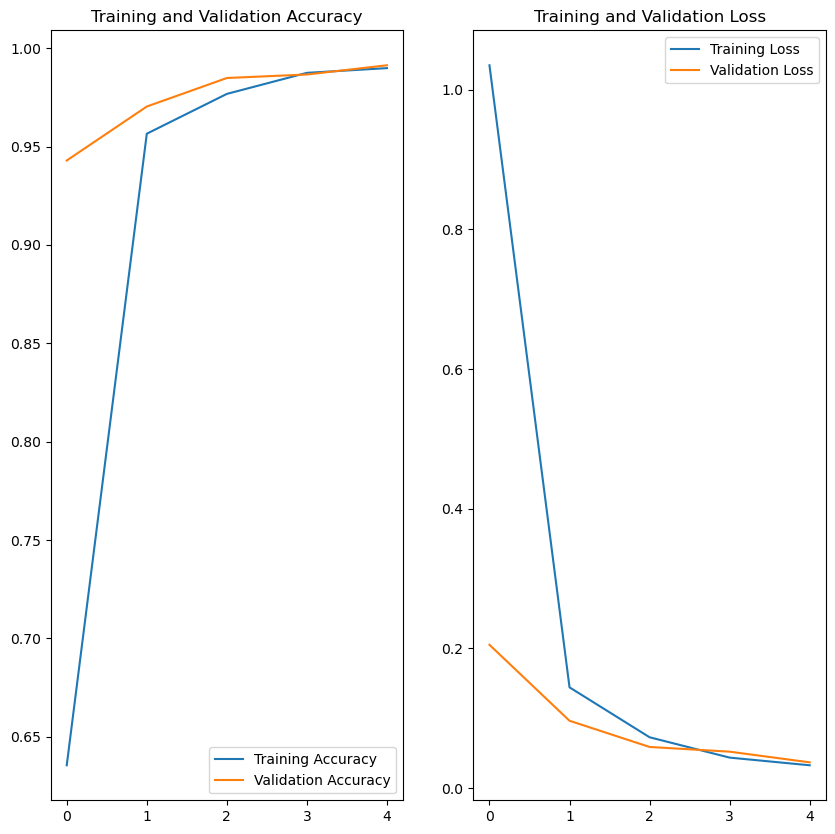

In [8]:
# visualizing accuracy and losses
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [9]:
# converting training data from image generator for prediction
test_data = image_dataset_from_directory(
    '/kaggle/input/state-farm-distracted-driver-detection/imgs/test',
    batch_size = 128,
    image_size=(100,100),
    labels = None,
    label_mode=None,
    shuffle = False
)

Found 79726 files belonging to 1 classes.


In [10]:
# function for predicting images
def predict_image(path):
    img = tf.keras.utils.load_img(path).resize((100,100))
    img = np.array(img).reshape((1,100,100,3))
    y = model.predict(img,verbose=False)
    return y
    

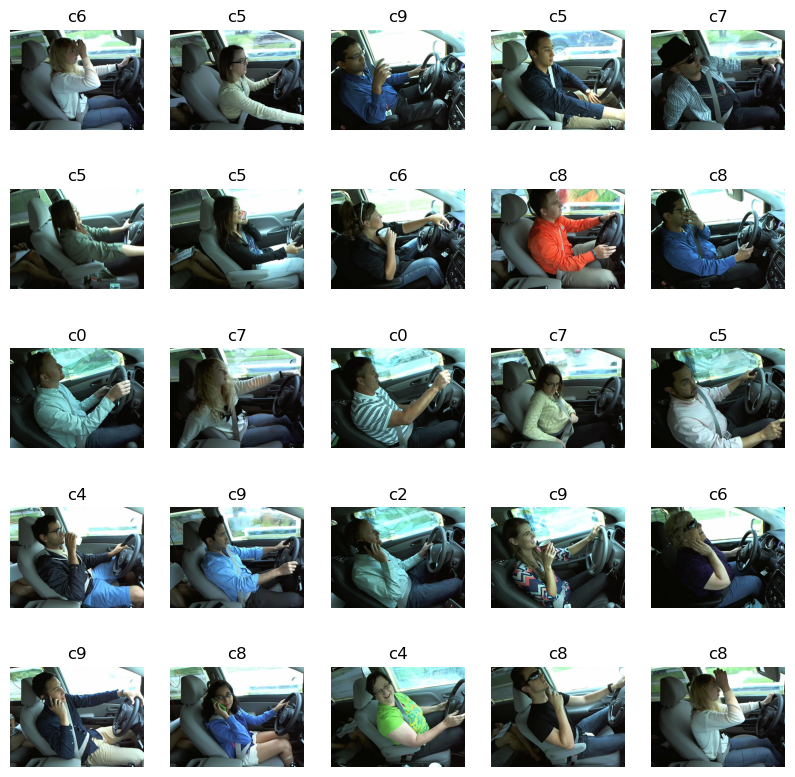

In [11]:
# predicting some test images
test_path = '/kaggle/input/state-farm-distracted-driver-detection/imgs/test'
plt.figure(figsize=(10,10))
i=1
for img_path in os.listdir(test_path)[:25]:
    img_path = os.path.join(test_path,img_path)
    img = tf.keras.utils.load_img(img_path)
    ax = plt.subplot(5, 5, i)
    plt.imshow(img)
    plt.title('c'+str(predict_image(img_path).argmax()))
    plt.axis("off")
    i += 1

In [12]:
# also use for predicting test data takes more time
# y = np.zeros((79726,10))
# test_dir = '/kaggle/input/state-farm-distracted-driver-detection/imgs/test'
# count = 0
# for i in tqdm(os.listdir(test_dir)):
#     path = os.path.join(test_dir,i)
#     y[count] = predict_image(path)
#     count += 1


In [13]:
#predicting test data given
y = model.predict(test_data)

623/623 [==============================] - 293s 470ms/step


In [14]:
y.shape

(79726, 10)

In [15]:
# exporting data as given
df = pd.DataFrame(y)
df.columns = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
filepath = [i.split('/')[-1] for i in test_data.file_paths]
df1 = pd.DataFrame(filepath)
df1.columns = ['img']
df = df1.join(df)
df.to_csv('/kaggle/working/output.csv',index=False)

In [16]:
df.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,1.088749e-12,3.732374e-20,6.233259e-14,2.413358e-16,1.527021e-12,1.000000,1.645619e-13,1.530903e-14,2.642424e-12,5.738844e-10
1,img_10.jpg,1.517270e-07,4.965084e-12,2.659493e-07,3.208189e-08,1.029379e-07,0.999996,3.489017e-07,1.983302e-08,2.816775e-07,2.376417e-06
2,img_100.jpg,2.658947e-01,1.513585e-03,2.018861e-04,9.487967e-04,1.025561e-02,0.003092,2.313487e-03,1.254761e-04,1.687570e-02,6.987784e-01
3,img_1000.jpg,2.522876e-05,3.286137e-04,1.295481e-04,1.191696e-05,4.339292e-04,0.000007,7.498819e-03,2.714906e-05,9.913009e-01,2.370659e-04
4,img_100000.jpg,2.422036e-03,2.721179e-07,2.507460e-06,2.304721e-04,7.869330e-02,0.101584,5.258324e-04,7.795251e-05,6.810088e-01,1.354545e-01
